# E. coli Tryptophan Network Construction
## Glucose Growth

In [1]:
# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass

import numpy as np

import pathlib
import pandas as pd
import altair as alt
import sympy as sym

import mass
from mass import MassModel, MassReaction, MassMetabolite, Simulation, MassConfiguration
from mass.io.json import (
    save_json_model as save_mass_json_model,
    load_json_model as load_mass_json_model,
)

import cobra
from cobra.io.json import load_json_model as load_cobra_json_model

print(f"COBRApy version: {cobra.__version__}")
print(f"MASSpy version: {mass.__version__}")

MASSCONFIG = MassConfiguration()
import warnings
warnings.filterwarnings("ignore")

Set parameter Username
Academic license - for non-commercial use only - expires 2022-01-21
COBRApy version: 0.22.1
MASSpy version: 0.1.5


## Set paths and constants

In [2]:
from cobra import Configuration
config = Configuration()
config.solver = "gurobi"

## Create Model of Tryptophan Network
### Load COBRA model

In [3]:
cobra_model = load_cobra_json_model(f"./models/cobra/iML1515.json")

### View network map via Escher

In [4]:
import escher

In [5]:
escher_builder = escher.Builder(
    model=cobra_model,
    map_json="./maps/Tryptophan_map.json",
    highlight_missing=True) 

escher_builder

Builder(highlight_missing=True)

## Obtain Flux State
### Load flux growth data

In [6]:
medium = "Glucose"

In [7]:
flux_data = pd.read_excel(
    io="./data/growth_data.xlsx",
    sheet_name="flux_data",
    index_col=0
)
flux_data = flux_data.loc[lambda x: x['Growth Medium'] == medium]
flux_data = flux_data.drop("Growth Medium", axis=1)
flux_data

,Flux (mmol * gDW-1 * h-1)
ID,
EX_ac_e,6.827019e+00
ACt2rpp,-6.827019e+00
ACKr,-6.827019e+00
PTAr,6.827019e+00
EX_glc__D_e,-9.654000e+00
GLCptspp,9.654000e+00
EX_fum_e,9.653732e-08
PGI,5.699970e+00
PFK,7.058477e+00


### Knockout reactions


In [8]:
#Knocking out TRPS2 and TRPS3
cobra_model.reactions.TRPS2.knock_out()
cobra_model.reactions.TRPS3.knock_out()
cobra_model.reactions.TRPAS2.knock_out()

### Formulate QP minimization for known fluxes and optimize

In [9]:
v_vars = []
v_data = []

# For irreversible enzyme pairs, flux data is given as Enzyme1 - Enzyme2 = value.
# To ensure all enzymes have some flux, add a percentage of the net flux for each enzyme
# The netflux will still remain the same value.
irreversible_enzyme_pairs = [["PFK", "FBP"], ["PYK", "PPS"]]
reverse_flux_percent = 0.1


for rid, flux in flux_data.itertuples():
#     if rid == "BIOMASS_Ec_iML1515_core_75p37M":
#         reaction = cobra_model.reactions.get_by_id(rid)
#         reaction.bounds = (flux, flux)
    # Ensure bounds are set to allow import from growth medium 
    if (rid == "EX_glc__D_e" and medium == "Glucose") or\
       (rid == "EX_pyr_e" and medium == "Pyruvate"):
        reaction = cobra_model.reactions.get_by_id(rid)
        reaction.bounds = ({"Glucose": -10000, "Pyruvate": -1000}.get(medium), 1000)
    # Make adjustments to net flux of PFK/FBP and PYK/PPS to ensure
    # no target flux value is 0 in order to create an enzyme module.
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_data.loc[irreversible_enzyme_pair, "Flux (mmol * gDW-1 * h-1)"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
            print(rid, flux)
    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)

# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)
F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
cobra_model.objective = objective[0]
cobra_model.objective_direction = "min"

flux_solution = cobra_model.optimize()

PFK 7.76432470140912
FBP 0.7058477001281019
PYK 2.7360389076214697
PPS 0.24873080978377


#### Compare fluxes

In [10]:
data = pd.concat(objs=(flux_data, flux_solution.fluxes), axis=1).dropna()
data = data.reset_index()
data.columns = ["Reaction ID", "Measured", "Computed"]

flux_compare = alt.Chart(
    data=data,
    width=300,
    height=300,
).mark_circle(size=60).encode(
    x='Measured:Q',
    y='Computed:Q',
    color='Reaction ID',
    tooltip=list(data.columns)
)
line = pd.DataFrame({
    'Measured': [-25, 25],
    'Computed':  [-25, 25],
})
line_plot = alt.Chart(line).mark_line(color= 'grey').encode(
    x='Measured',
    y='Computed',
)
flux_compare += line_plot
flux_compare

alt.LayerChart(...)

In [11]:
flux_solution["TRPt2rpp"]

0.0

### Create MASS model


In [12]:
# Create MassModel
mass_model = MassModel("Tryptophan", array_type="DataFrame")

# Reactions to extract into subnetwork
reaction_list = [
    "TRPt2rpp",
    "PGI", 
    "PFK", 
    "FBP", 
    "FBA", 
    "TPI", 
    "GAPD",
    "PGK", 
    "PGM", 
    "ENO", 
    "PYK", 
    "PPS", 
    #"LDH_D",
    "PGCD",
    "PSERT",
    "PSP_L",
    "CHORS",
    "DDPA", 
    "DHQS",
    "DHQTi",
    "PSCVT",
    "SHK3Dr",
    "SHKK", 
    "TALA", 
    "G6PDH2r",
    "GND",
    "RPI",
    "TKT1", 
    "TKT2", 
    "ANS", 
    "ANPRT", 
    "IGPS",
    "PRAIi",
    "TRPS1",
    #"TRPS3",
    #"TRPS2",
    "RPE",
    "PGL",
    ]


cobra_reactions = cobra_model.reactions.get_by_any(reaction_list)
mass_model.add_reactions([MassReaction(rxn) for rxn in cobra_reactions])
mass_model

Name,Tryptophan
Memory address,0x07fa151a39730
Stoichiometric Matrix,50x35
Matrix Rank,35
Number of metabolites,50
Initial conditions defined,0/50
Number of reactions,35
Number of genes,34
Number of enzyme modules,0
Number of groups,0
Objective expression,0


#### Convert units

In [13]:
growth_rate = flux_data.loc[cobra_model.reactions.BIOMASS_Ec_iML1515_core_75p37M.id][0]

In [14]:
T = 313.15
gas_constant = 0.00831446261815324
e_coli_density = 1.1 # g / mL assumption
volume = 3.2  # femtoliter
# Perform conversions
doubling_time_per_minute = np.log(2) / growth_rate * 60
cell_gDW = 41932 * doubling_time_per_minute**-1.232 * 1e-15
real_cell_total_weight = e_coli_density * (volume * 1e-12) # fL --> mL
# Assume water is 70%
adj_volume = volume * 0.7
gDW_L_conversion_factor = real_cell_total_weight / (adj_volume * 1e-15)
gDW_L_conversion_factor

1571.4285714285716

#### Set fluxes

In [15]:
for reaction in mass_model.reactions.get_by_any(reaction_list):
    flux = flux_solution[reaction.id]
    if reaction.id == "TRPt2rpp" and flux == 0:
        flux+= 0.000001
    # Convert mmol * gDW-1 * h-1 --> Mole / L / hr
    reaction.steady_state_flux = flux * gDW_L_conversion_factor * 0.001
    print(f"{reaction.id}: {flux}")

TRPt2rpp: 1e-06
PGI: 5.699970323068908
PFK: 7.76432470140896
FBP: 0.7058477001281019
FBA: 7.058477001280537
TPI: 6.939053258455148
GAPD: 15.7103918012915
PGK: -15.7103918012915
PGM: -14.563006476638412
ENO: 14.563006476638412
PYK: 2.730736632272458
PPS: 0.2540330851327814
PGCD: 1.1473853246530883
PSERT: 1.1473853246530883
PSP_L: 1.1473853246530883
CHORS: 0.21777740347047927
DDPA: 0.21777740347047927
DHQS: 0.21777740347047927
DHQTi: 0.21777740347047927
PSCVT: 0.21777740347047927
SHK3Dr: 0.21777740347047927
SHKK: 0.21777740347047927
TALA: 0.7890502053825126
G6PDH2r: 3.919275276928566
GND: 2.8322842173013867
RPI: -1.4246592188045506
TKT1: 0.8025360834477786
TKT2: 0.584644139101096
ANS: 0.02919662343508119
ANPRT: 0.02919662343508119
IGPS: 0.02919662343508119
PRAIi: 0.02919662343508119
TRPS1: 0.02919662343508119
RPE: 1.3871802225488747
PGL: 3.919275276928566


### Obtain Concentrations

#### Set equilibrium constants


In [16]:
Keq_data = pd.read_excel(
    io="./data/growth_data.xlsx",
    sheet_name="Keq_data",
    index_col=0
)

Keq_data = Keq_data.drop("Stoichiometry", axis=1)
# Set equilibrium constants
for reaction in mass_model.reactions.get_by_any(reaction_list):
    try:
        Keq = Keq_data.loc[reaction.id, :][0]
        reaction.equilibrium_constant = Keq 
    except KeyError as e:
        print(f"No Keq data for {e}")
        if reaction.id == "TRPt2rpp":
            reaction.equilibrium_constant = 1
    
    print(f"{reaction.Keq_str}: {reaction.equilibrium_constant}")

No Keq data for 'TRPt2rpp'
Keq_TRPt2rpp: 1
Keq_PGI: 0.372679859
Keq_PFK: 1022.334096
Keq_FBP: 64.75642481
Keq_FBA: 0.000102656
Keq_TPI: 0.087276143
Keq_GAPD: 0.627040514
Keq_PGK: 0.000670855
Keq_PGM: 2.981497079
Keq_ENO: 6.69595445
Keq_PYK: 17602.30756
Keq_PPS: 2.209787365
Keq_PGCD: 7.58e-06
Keq_PSERT: 52.82458434
Keq_PSP_L: 27.02318343
Keq_CHORS: 134000000000.0
Keq_DDPA: 2340000000000.0
Keq_DHQS: 3.46e+17
Keq_DHQTi: 7.045333375
Keq_PSCVT: 770.0
Keq_SHK3Dr: 15.9
Keq_SHKK: 32000.0
Keq_TALA: 1.1899999992265
Keq_G6PDH2r: 15.663669
Keq_GND: 0.050066728
Keq_RPI: 0.579698787
Keq_TKT1: 2.589775912
Keq_TKT2: 28.10232048
Keq_ANS: 1.13e+16
Keq_ANPRT: 2190000000000.0
Keq_IGPS: 220000000000.0
Keq_PRAIi: 38.71017608
Keq_TRPS1: 135031.8001
Keq_RPE: 1.979534309
Keq_PGL: 35988.51087


In [17]:
# Potentially missing
['ara5p_c', 'indole_c']

['ara5p_c', 'indole_c']

### Set concentrations

In [18]:
conc_data = pd.read_excel(
    io="./data/growth_data.xlsx",
    sheet_name="conc_data",
    index_col=0
)
conc_data = conc_data.loc[lambda x: x['Growth Medium'] == "Glucose"]
conc_data = conc_data.drop("Growth Medium", axis=1)
conc_data = conc_data.drop("Name", axis=1)
conc_data

,Concentration (mol * L-1)
ID,
g6p_c,0.000843
13dpg_c,0.000045
2pg_c,0.000150
3pg_c,0.000500
6pgc_c,0.000247
adp_c,0.000708
akg_c,0.000532
amp_c,0.000428
anth_c,0.000003


#### Add metabolites in enzymes that not present in MASS model
This includes ``indole_c`` and `ara5p_c`

In [19]:
missing_metabolites = ["indole_c", "ara5p_c"]
for mid in missing_metabolites:
    metabolite = MassMetabolite(cobra_model.metabolites.get_by_id(mid))
    metabolite.fixed = True
    mass_model.add_metabolites([metabolite])
    

In [20]:
for metabolite in ["h2o_c", "h_c"]:
    metabolite = mass_model.metabolites.get_by_id(metabolite)
    metabolite.fixed = True
    metabolite.initial_condition = 1

In [21]:
mass_model.update_initial_conditions({
    mid: value for mid, value in conc_data.itertuples()
})
missing_ics = mass_model.metabolites.query(lambda m: m.initial_condition is None)

In [22]:
# Provide initial guesses
for metabolite in missing_ics:
    if metabolite.id in ['anth_c', 'glc__D_p', "trp__L_p", "ara5p_c"]:
        metabolite.initial_condition = 0.001
    if metabolite.id in ["indole_c"]:
        metabolite.initial_condition = 0.000001
missing_ics = mass_model.metabolites.query(lambda m: m.initial_condition is None)
missing_ics

[<MassMetabolite h_p at 0x7fa150cfd8b0>,
 <MassMetabolite 3php_c at 0x7fa151a3a0a0>,
 <MassMetabolite pser__L_c at 0x7fa151a2a790>,
 <MassMetabolite 3psme_c at 0x7fa170f4c910>,
 <MassMetabolite chor_c at 0x7fa170f4c880>,
 <MassMetabolite 2dda7p_c at 0x7fa170f4cb50>,
 <MassMetabolite 3dhq_c at 0x7fa170f4c760>,
 <MassMetabolite 3dhsk_c at 0x7fa170f4c580>,
 <MassMetabolite skm5p_c at 0x7fa170f4c940>,
 <MassMetabolite 6pgl_c at 0x7fa170f4a730>,
 <MassMetabolite pran_c at 0x7fa151a38730>,
 <MassMetabolite 2cpr5p_c at 0x7fa151a387f0>,
 <MassMetabolite 3ig3p_c at 0x7fa151a387c0>]

In [23]:
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

In [24]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    zero_value_log_substitute=1e-7,

)

conc_solver.setup_feasible_qp_problem(
    fixed_conc_bounds=list(mass_model.fixed),
    fixed_Keq_bounds=mass_model.reactions.list_attr("Keq_str")
)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
h_p,2.692905e-02,0.000000
trp__L_c,9.906642e-06,0.000000
trp__L_p,1.000000e-03,0.000000
f6p_c,1.856195e-04,0.000000
g6p_c,1.353886e-03,0.000000
...,...,...
Keq_IGPS,2.200000e+11,0.000000
Keq_PRAIi,3.871018e+01,0.000000
Keq_TRPS1,1.350318e+05,0.000000
Keq_RPE,1.979534e+00,-0.317674


In [25]:
data = pd.concat(objs=(conc_data, conc_solution.concentrations), axis=1).dropna()
data = data.reset_index()
data.columns = ["Metabolite ID", "Measured", "Computed"]

conc_compare = alt.Chart(
    data=data,
    width=300,
    height=300,
).mark_circle(size=60).encode(
    alt.X('Measured', type='quantitative', scale=alt.Scale(type="log")),
    alt.Y('Computed', type='quantitative', scale=alt.Scale(type="log")),
    color='Metabolite ID',
    tooltip=list(data.columns)
)
line = pd.DataFrame({
    'Measured': [1e-7, .1],
    'Computed':  [1e-7, .1],
})
line_plot = alt.Chart(line).mark_line(color= 'grey').encode(
    x='Measured',
    y='Computed',
)
conc_compare += line_plot
conc_compare

alt.LayerChart(...)

#### Sample Concentrations

In [26]:
n_models = 5

In [27]:
# Fix Metabolite IDs as SBML compatible
for metabolite in mass_model.metabolites:
    if metabolite.id[0].isdigit():
        metabolite.id = f"_{metabolite.id}"
mass_model.repair()

In [28]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,

)

conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(mass_model.fixed),
    fixed_Keq_bounds=mass_model.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = mass_model.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=4)
conc_samples

,h_p,trp__L_c,trp__L_p,f6p_c,g6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,xu5p__D_c,anth_c,gln__L_c,ppi_c,pran_c,prpp_c,_2cpr5p_c,_3ig3p_c,indole_c,ara5p_c
0,0.012034,0.000044,0.009951,0.000676,0.008391,0.000794,0.005416,0.002911,0.012690,0.002073,...,0.000652,3.079048e-06,0.001478,0.000045,1.936006e-04,0.000096,4.801146e-04,4.298259e+03,1.128080e-07,0.000103
1,0.010996,0.000023,0.005574,0.000386,0.006705,0.000214,0.000438,0.002495,0.002908,0.002253,...,0.000460,3.999060e-07,0.000349,0.000049,6.746305e-07,0.000053,7.573735e-08,1.118244e-03,2.050307e-07,0.000139
2,0.016313,0.000023,0.003835,0.000401,0.003095,0.000424,0.000259,0.002372,0.007756,0.002515,...,0.000581,1.316601e-06,0.000540,0.000050,1.065640e-05,0.000071,1.171794e-06,1.915814e+05,1.860978e-07,0.000320
3,0.013066,0.000024,0.005020,0.000311,0.004397,0.000146,0.000310,0.003490,0.006584,0.003161,...,0.000894,1.191125e-06,0.000654,0.000051,3.470685e-04,0.000102,4.158359e-05,2.286251e+07,1.359500e-07,0.000238
4,0.012640,0.000009,0.002039,0.000191,0.002245,0.000249,0.000471,0.005626,0.004846,0.001495,...,0.000512,1.319464e-06,0.000497,0.000053,8.040377e-04,0.000112,2.508171e-05,1.664294e+03,2.469938e-07,0.000176


May take a few minutes to run

In [29]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = mass_model.copy()
    new_model.id += "_C{0:d}".format(idx)
    print(f"Creating model {new_model.id}")
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)
    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

Creating model Tryptophan_C0
Creating model Tryptophan_C1
Creating model Tryptophan_C2
Creating model Tryptophan_C3
Creating model Tryptophan_C4
Number of models in ensemble: 5


### Create Enzyme Modules

In [30]:
import matplotlib.pyplot as plt

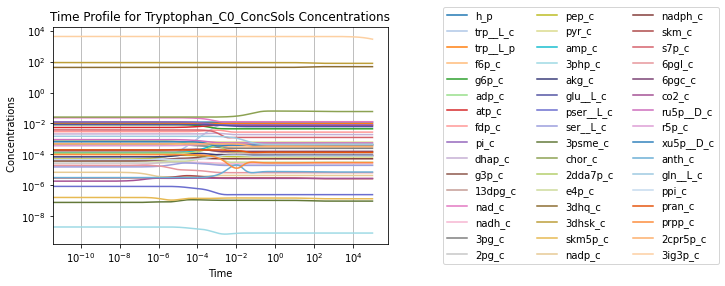

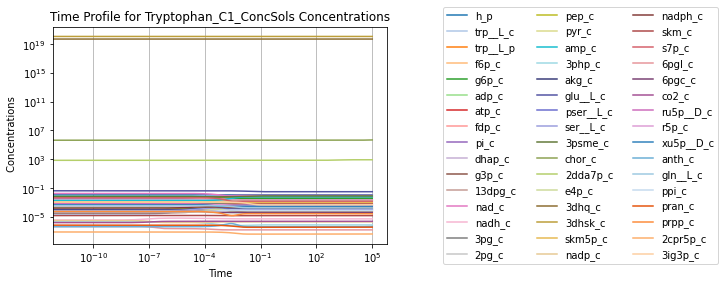

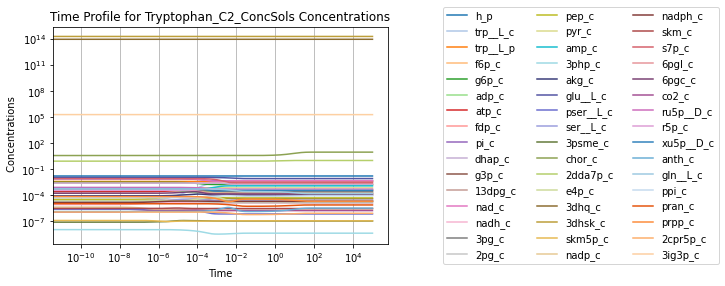

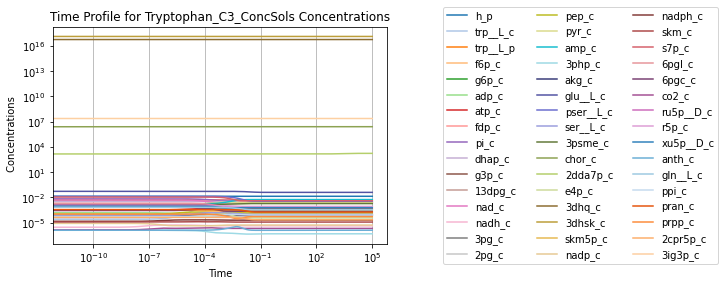

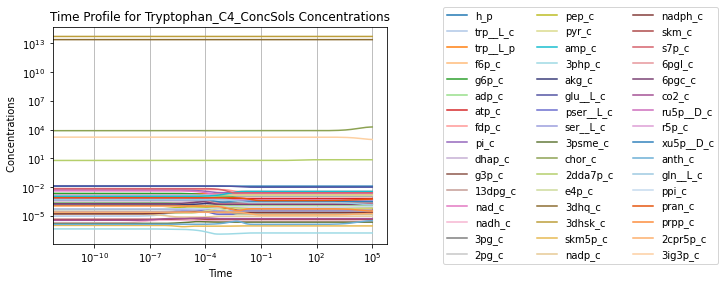

In [31]:
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
models_to_export = []
sim = Simulation(reference_model=models_for_ensemble[0])
sim.integrator.maximum_time_step = 100
sim.add_models(models_for_ensemble[1:], disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9
for model in models_for_ensemble.copy():
    # Attempt to determine steady state
    conc_sol, flux_sol = sim.simulate(
        models=model,
        time=(0, 1e5)
    )
    model.update_initial_conditions(
        {k: v for k, v in conc_sol.items()}
    )
    conc_sol.view_time_profile()
    plt.show()
    save_mass_json_model(
        mass_model=model,
        filename=f"./models/mass/without_enzymes/{model.id}.json")

In [32]:
from enzyme_construction import make_enzyme_module_from_dir

In [33]:
isozyme1_percent = 0.50
isozyme2_percent = 1 - isozyme1_percent

# Isozymes and flux split percentages,
isozymes_and_flux_splits = {
    "PFK": {
        "PFK1": isozyme1_percent,
        "PFK2": isozyme2_percent,
    },
    "FBP": {
        "FBP1": isozyme1_percent,
        "FBP2": isozyme2_percent,
    },
    "FBA": {
        "FBA1": isozyme1_percent,
        "FBA2": isozyme2_percent,
    },
    "PGM": {
        "PGMi": isozyme1_percent,
        "PGMd": isozyme2_percent,
    },
    "PYK": {
        "PYK1": isozyme1_percent,
        "PYK2": isozyme2_percent,
    },
    "DDPA": {
        "DDPA_iso_1": isozyme1_percent,
        "DDPA_iso_2": isozyme2_percent,
    },
    "RPI": {
        "RPIa": isozyme1_percent,
        "RPIb": isozyme2_percent,
    },
    "SHK3Dr": {
        "SHK3Dr_iso_1": isozyme1_percent,
        "SHK3Dr_iso_2": isozyme2_percent,
    },
    "SHKK": {
        "SHKK_iso_1": isozyme1_percent,
        "SHKK_iso_2": isozyme2_percent,
    },
}
        
isozymes_and_flux_splits

{'PFK': {'PFK1': 0.5, 'PFK2': 0.5},
 'FBP': {'FBP1': 0.5, 'FBP2': 0.5},
 'FBA': {'FBA1': 0.5, 'FBA2': 0.5},
 'PGM': {'PGMi': 0.5, 'PGMd': 0.5},
 'PYK': {'PYK1': 0.5, 'PYK2': 0.5},
 'DDPA': {'DDPA_iso_1': 0.5, 'DDPA_iso_2': 0.5},
 'RPI': {'RPIa': 0.5, 'RPIb': 0.5},
 'SHK3Dr': {'SHK3Dr_iso_1': 0.5, 'SHK3Dr_iso_2': 0.5},
 'SHKK': {'SHKK_iso_1': 0.5, 'SHKK_iso_2': 0.5}}

May take a few minutes to run

In [36]:
final_ensemble = []
for new_model in models_for_ensemble.copy():
    new_model = new_model.copy()
    enzyme_modules = {}
    try:
        for reaction in new_model.reactions.get_by_any(reaction_list):
             # Make isozymes
            flux = reaction.steady_state_flux
            print(reaction.id, flux)
            if reaction.id in isozymes_and_flux_splits:
                isozymes_and_flux_split = isozymes_and_flux_splits[reaction.id]
                isozyme_modules = []
                for isozyme, flux_split in isozymes_and_flux_split.items():
                    enzyme_module = make_enzyme_module_from_dir(
                        enzyme_id=isozyme,
                        steady_state_flux=flux * flux_split, # Split flux for isozymes
                        metabolite_concentrations=new_model.initial_conditions,
                        path_to_dir="./data/enzyme_data",
                        kcluster=1,
                        enzyme_gpr=None,
                        zero_tol=1e-10)
                    isozyme_modules += [enzyme_module]
                enzyme_modules[reaction] = isozyme_modules
            elif reaction.id not in ["GLCptspp", "TRPt2rpp"]:
                enzyme_module = make_enzyme_module_from_dir(
                    enzyme_id=reaction.id,
                    steady_state_flux=flux, # Split flux for isozymes
                    metabolite_concentrations=new_model.initial_conditions,
                    path_to_dir="./data/enzyme_data",
                    kcluster=1,
                    enzyme_gpr=None,
                    zero_tol=1e-10)
                enzyme_modules[reaction] = [enzyme_module]
            else:
                continue

        for reaction_to_remove, enzymes_to_add in enzyme_modules.items():
            new_model.remove_reactions([reaction_to_remove])
            for enzyme in enzymes_to_add:
                new_model = new_model.merge(enzyme, inplace=True)
    except Exception as e:
        print("Could not create EnzymeModules for {0} due to issues with {1}.".format(new_model.id, reaction.id))
        print(e)
        continue
            
    final_ensemble += [new_model]
    print(f"Finished {new_model.id}")

TRPt2rpp 1.5714285714285714e-06
PGI 8.957096221965429
PFK 12.201081673642651
FBP 1.109189243058446
FBA 11.091892430583703
TPI 10.90422654900095
GAPD 24.687758544886645
PGK -24.687758544886645
PGM -22.884724463288936
ENO 22.884724463288936
PYK 4.291157564999578
PPS 0.39919484806579936
PGCD 1.8030340815977104
PSERT 1.8030340815977104
PSP_L 1.8030340815977104
CHORS 0.3422216340250389
DDPA 0.3422216340250389
DHQS 0.3422216340250389
DHQTi 0.3422216340250389
PSCVT 0.3422216340250389
SHK3Dr 0.3422216340250389
SHKK 0.3422216340250389
TALA 1.2399360370296626
G6PDH2r 6.1588611494591765
GND 4.450732341473609
RPI -2.23875020097858
TKT1 1.2611281311322238
TKT2 0.9187265043017224
ANS 0.04588040825512759
ANPRT 0.04588040825512759
IGPS 0.04588040825512759
PRAIi 0.04588040825512759
TRPS1 0.04588040825512759
RPE 2.179854635433946
PGL 6.1588611494591765
Finished Tryptophan_C0
TRPt2rpp 1.5714285714285714e-06
PGI 8.957096221965429
PFK 12.201081673642651
FBP 1.109189243058446
FBA 11.091892430583703
TPI 10.9

In [37]:
final_ensemble

[<MassModel Tryptophan_C0 at 0x7fa1a1fe3cd0>,
 <MassModel Tryptophan_C2 at 0x7fa1a1eb3af0>]

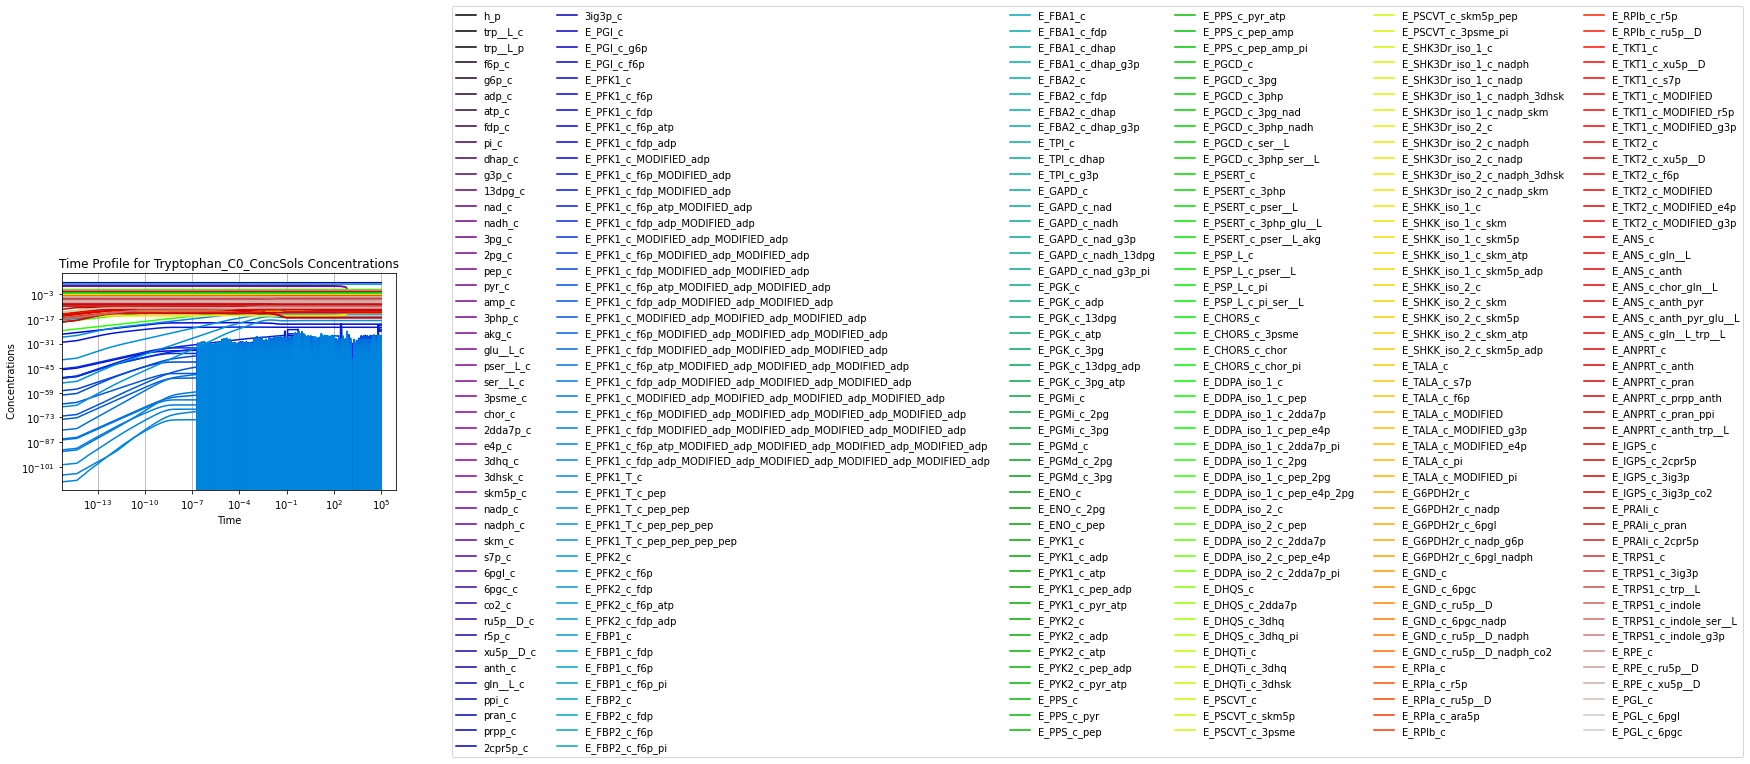

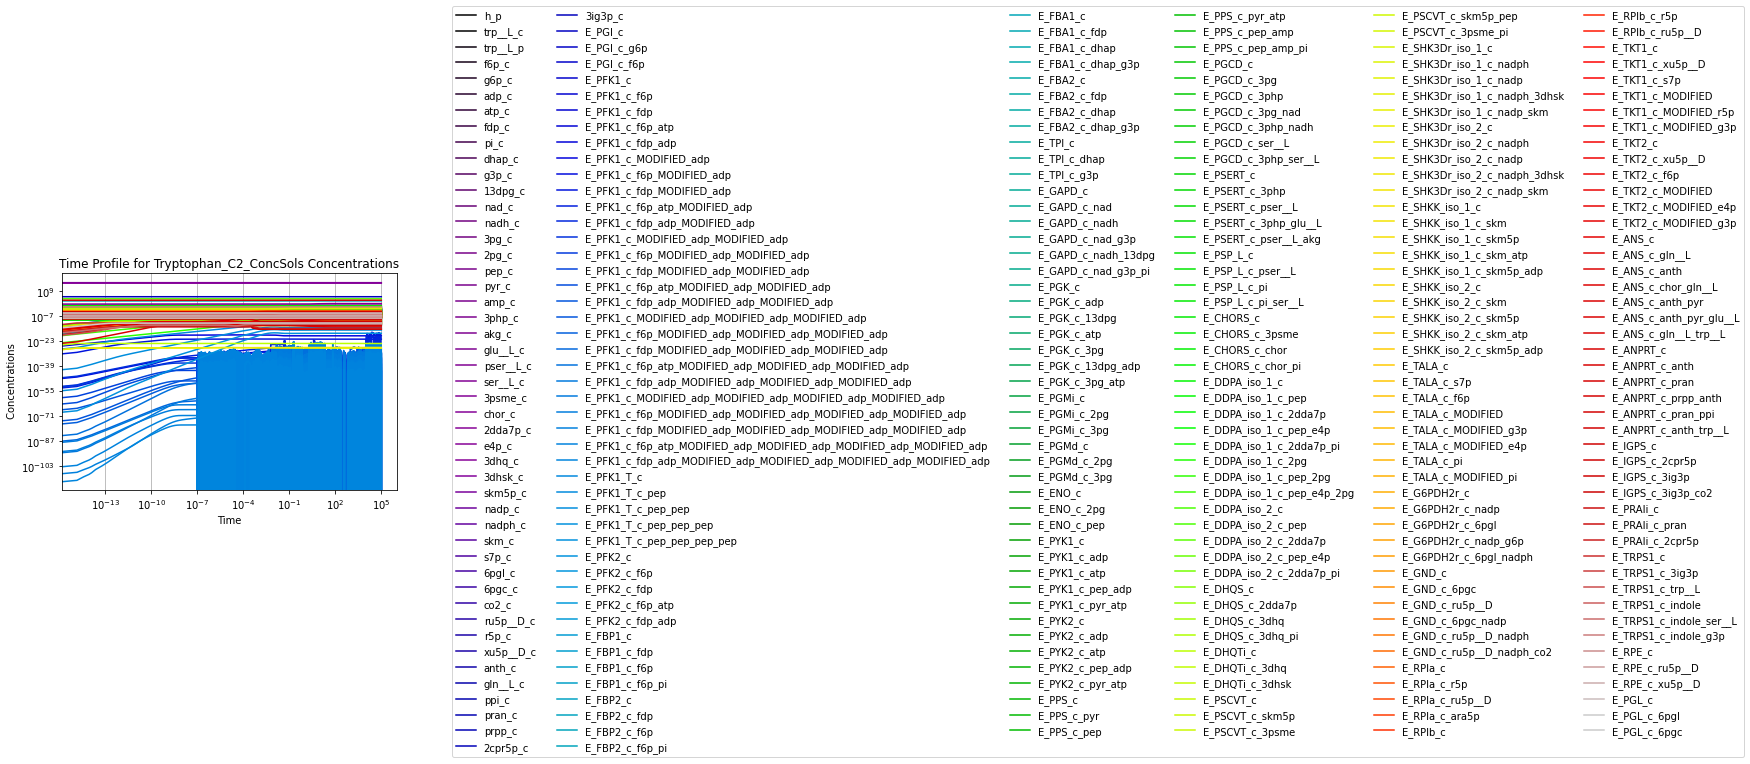

In [38]:
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
sim = Simulation(reference_model=final_ensemble[0])
sim.integrator.maximum_time_step = 100
sim.add_models(final_ensemble[1:], disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9
for model in final_ensemble.copy():
#      Attempt to determine steady state
    conc_sol, flux_sol = sim.simulate(
        models=model,
        time=(0, 1e5)
    )
    conc_sol.view_time_profile()
    plt.show()
    model.update_initial_conditions(
        {k: v for k, v in conc_sol.items()}
    )
    save_mass_json_model(
        mass_model=model,
        filename=f"./models/mass/with_enzymes/{model.id}.json")